In [1]:
import os
import cv2
import numpy as np
import trimesh
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
from utils.people_snapshot_dataset import People_Snapshot_Dataset
from utils.multi_garment_dataset import Multi_Garment_Dataset
from utils.iper_dataset import iPER_Dataset
from models.networks.smpl import SMPL
from models.networks.render import SMPLRenderer
from utils.util import load_obj, load_pickle_file, write_pickle_file

In [2]:
torch.cuda.set_device(1)

In [3]:
data_root = 'data/Multi-Garment_dataset'
vis_result_dir = 'outputs/vis_result_3D'
isHres = True
image_size = 256
batch_size = 6
num_frame = 8

In [4]:
smpl = SMPL(pkl_path='assets/smpl_model.pkl', isHres=isHres).cuda()
if isHres:
    faces = smpl.faces_hres
else:
    faces = smpl.faces
smpl_render = SMPLRenderer(faces=faces).cuda()

In [5]:
smpl_render.set_bg_color((1, 1, 1))

In [6]:
smpl_render.set_ambient_light(int_dir=0.3, int_amb=0.7, direction=(1, 0.5, 0.5))

In [7]:
train_dataset = Multi_Garment_Dataset(data_root=data_root, num_frame=num_frame, isHres=isHres)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
for i, data in enumerate(train_loader):
    
    shape = data['shape'].cuda()
    pose = data['pose'].cuda()
    cam = data['cam'].cuda()
    poses = data['poses'].cuda()
    cams = data['cams'].cuda()
    v_personal = data['v_personal'].cuda()
    uv_image = data['uv_image'].cuda()
    f2vts = data['f2vts'].cuda()
    
    tex = smpl_render.extract_tex(uv_image, smpl_render.points_to_sampler(f2vts))
    
    print('shape: ', shape.size())
    print('pose: ', pose.size())
    print('cam: ', cam.size())
    print('poses: ', poses.size())
    print('cams: ', cams.size())
    print('v_personal: ', v_personal.size())
    print('uv_image: ', uv_image.size())
    print('f2vts: ', f2vts.size())
    print('tex: ', tex.size())
    
    if i >= 0:
        break

shape:  torch.Size([6, 10])
pose:  torch.Size([6, 72])
cam:  torch.Size([6, 3])
poses:  torch.Size([6, 8, 72])
cams:  torch.Size([6, 8, 3])
v_personal:  torch.Size([6, 27554, 3])
uv_image:  torch.Size([6, 3, 2048, 2048])
f2vts:  torch.Size([6, 55104, 3, 2])
tex:  torch.Size([6, 55104, 3, 3, 3, 3])


In [9]:
verts_personal = smpl(shape, pose, v_personal)
verts_personal = smpl_render.project_to_image(verts_personal, cam, flip=False, withz=True)
img_masked_personal = smpl_render.render(verts_personal, tex)
print(img_masked_personal.size())

torch.Size([6, 3, 256, 256])


In [10]:
pose_T = torch.zeros_like(pose).cuda()

In [11]:
verts_T = smpl(shape, pose_T)
verts_T = smpl_render.project_to_image(verts_T, cam, flip=False, withz=True)

In [12]:
verts_T_personal = smpl(shape, pose_T, v_personal * 0.5)
verts_T_personal = smpl_render.project_to_image(verts_T_personal, cam, flip=False, withz=True)

In [13]:
verts_T_personal_gt = smpl(shape, pose_T, v_personal)
verts_T_personal_gt = smpl_render.project_to_image(verts_T_personal_gt, cam, flip=False, withz=True)

In [14]:
img_smpl = smpl_render.render(verts_T)
print(img_smpl.size())

torch.Size([6, 3, 256, 256])


In [15]:
img_smpl_personal = smpl_render.render(verts_T_personal)
print(img_smpl_personal.size())

torch.Size([6, 3, 256, 256])


In [16]:
img_smpl_personal_gt = smpl_render.render(verts_T_personal_gt)
print(img_smpl_personal_gt.size())

torch.Size([6, 3, 256, 256])


In [17]:
for i in range(batch_size):
    save_image(img_masked_personal[i].detach().cpu(), os.path.join(vis_result_dir, 'img_masked_personal_{}.jpg'.format(i)))
    save_image(img_smpl[i].detach().cpu(), os.path.join(vis_result_dir, 'img_smpl_{}.jpg'.format(i)))
    save_image(img_smpl_personal[i].detach().cpu(), os.path.join(vis_result_dir, 'img_smpl_personal_{}.jpg'.format(i)))
    save_image(img_smpl_personal_gt[i].detach().cpu(), os.path.join(vis_result_dir, 'img_smpl_personal_gt_{}.jpg'.format(i)))
    shape_ref = shape[i][None].repeat(num_frame, 1)
    pose_ref = poses[i]
    cam_ref = cams[i]
    v_personal_ref = v_personal[i][None].repeat(num_frame, 1, 1)
    tex_ref = tex[i][None].repeat(num_frame, 1, 1, 1, 1, 1)
    
    print('shape_ref: ', shape_ref.size())
    print('pose_ref: ', pose_ref.size())
    print('cam_ref: ', cam_ref.size())
    print('v_personal_ref: ', v_personal_ref.size())
    print('tex_ref: ', tex_ref.size())
    
    verts_ref = smpl(shape_ref, pose_ref, v_personal_ref)
    print('verts_ref: ', verts_ref.size())
    verts_ref = smpl_render.project_to_image(verts_ref, cam_ref, flip=True, withz=True)
    img_masked_ref_personal = smpl_render.render(verts_ref, tex_ref)
    img_smpl_ref_personal = smpl_render.render(verts_ref)
    print(img_masked_ref_personal.size())
    save_image(img_masked_ref_personal.detach().cpu(), os.path.join(vis_result_dir, 'img_masked_refs_personal_gt_{}.jpg'.format(i)), nrow=num_frame)
    save_image(img_smpl_ref_personal.detach().cpu(), os.path.join(vis_result_dir, 'img_smpl_refs_personal_gt_{}.jpg'.format(i)), nrow=num_frame)

shape_ref:  torch.Size([8, 10])
pose_ref:  torch.Size([8, 72])
cam_ref:  torch.Size([8, 3])
v_personal_ref:  torch.Size([8, 27554, 3])
tex_ref:  torch.Size([8, 55104, 3, 3, 3, 3])
verts_ref:  torch.Size([8, 27554, 3])
torch.Size([8, 3, 256, 256])
shape_ref:  torch.Size([8, 10])
pose_ref:  torch.Size([8, 72])
cam_ref:  torch.Size([8, 3])
v_personal_ref:  torch.Size([8, 27554, 3])
tex_ref:  torch.Size([8, 55104, 3, 3, 3, 3])
verts_ref:  torch.Size([8, 27554, 3])
torch.Size([8, 3, 256, 256])
shape_ref:  torch.Size([8, 10])
pose_ref:  torch.Size([8, 72])
cam_ref:  torch.Size([8, 3])
v_personal_ref:  torch.Size([8, 27554, 3])
tex_ref:  torch.Size([8, 55104, 3, 3, 3, 3])
verts_ref:  torch.Size([8, 27554, 3])
torch.Size([8, 3, 256, 256])
shape_ref:  torch.Size([8, 10])
pose_ref:  torch.Size([8, 72])
cam_ref:  torch.Size([8, 3])
v_personal_ref:  torch.Size([8, 27554, 3])
tex_ref:  torch.Size([8, 55104, 3, 3, 3, 3])
verts_ref:  torch.Size([8, 27554, 3])
torch.Size([8, 3, 256, 256])
shape_ref:  

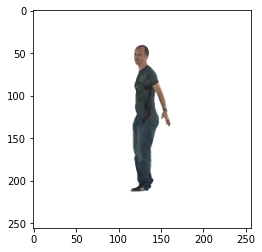

In [18]:
img_masked_ref_personal_vis = (img_masked_ref_personal.detach().cpu().numpy()[0] * 255).astype(np.uint8).transpose(1, 2, 0)
plt.imshow(img_masked_ref_personal_vis)

In [19]:
vis_ID = 2

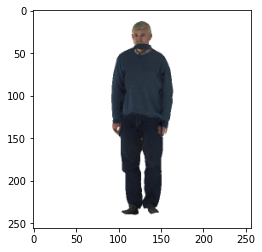

In [20]:
img_masked_personal_vis = (img_masked_personal.detach().cpu().numpy()[vis_ID] * 255).astype(np.uint8).transpose(1, 2, 0)
plt.imshow(img_masked_personal_vis)

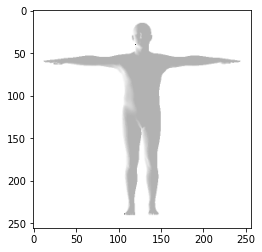

In [21]:
img_smpl_vis = (img_smpl.detach().cpu().numpy()[vis_ID] * 255).astype(np.uint8).transpose(1, 2, 0)
plt.imshow(img_smpl_vis)

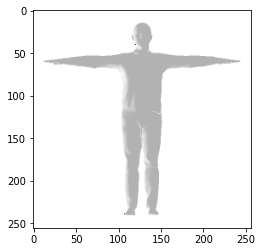

In [22]:
img_smpl_personal_vis = (img_smpl_personal.detach().cpu().numpy()[vis_ID] * 255).astype(np.uint8).transpose(1, 2, 0)
plt.imshow(img_smpl_personal_vis)

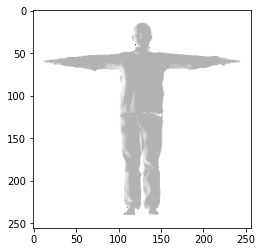

In [23]:
img_smpl_personal_gt_vis = (img_smpl_personal_gt.detach().cpu().numpy()[vis_ID] * 255).astype(np.uint8).transpose(1, 2, 0)
plt.imshow(img_smpl_personal_gt_vis)